In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import heamy
import random

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, LeaveOneOut
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from skopt import gp_minimize, forest_minimize, gbrt_minimize
from skopt.space import Categorical
from sklearn.multiclass import OneVsOneClassifier

# just in case so we have reproducible results
random.seed(92016)
np.random.seed(92016)


%matplotlib inline

# Data analysis
The first step in a machine learning project is to load the data and get a sense for what we are looking at.

In [2]:
train = pd.read_csv('data/train.zip')
test = pd.read_csv('data/test.csv.zip')

## Training data
After loading in our training and test data the next step should be printing out the tabular data.

In [3]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


## Submission data
Now lets look at the submission data.

In [4]:
test.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color
0,3,0.471774,0.387937,0.706087,0.698537,black
1,6,0.427332,0.645024,0.565558,0.451462,white
2,9,0.549602,0.491931,0.660387,0.449809,black
3,10,0.638095,0.682867,0.471409,0.356924,white
4,13,0.361762,0.583997,0.377256,0.276364,black


In [7]:
features = train.columns[1:-1]
numeric_features = features[:-1]

In [8]:
print(features)
print(numeric_features)

Index(['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'color'], dtype='object')
Index(['bone_length', 'rotting_flesh', 'hair_length', 'has_soul'], dtype='object')


## Features
Looking at the data we have a few different features. 

### Numerical Features
`bone_length`, `rotting_flesh`, `hair_length`, and `has_soul` are all continuous numerical variables.

### Categorical Features
The feature `color` is catagorical meaning it takes on a few discrete types. The numerical features we can use directly, but the categorical feature will need some processing so we can use it with most machine learning models.

### Response
The column `type` is the response, meaning the thing we are going to predict. If we look at the test data we can see taht this column is missing. Thats `type` is what we are trying to predict. We want our model to train on `bone_length`, `rotting_flesh`, `hair_length`, and `has_soul` and `color` and then make predictions as to which type of Monster the current sample is describing.

### Graphing
We can graph these continuous features against the categorical features to try and find patterns in the data to help us with our predictions. Lets look at the distributions of the numeric variables. To start, lets make some scatter plots and distributions.

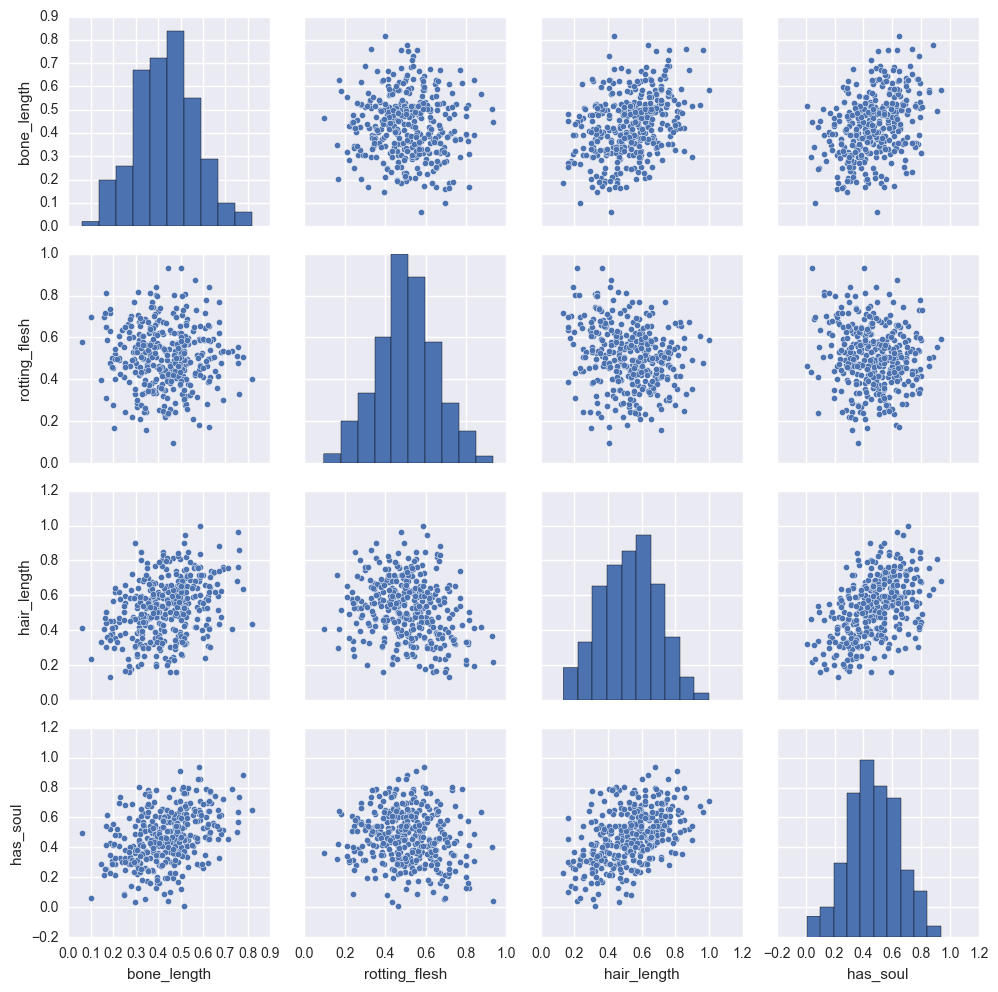

In [8]:
sns.pairplot(train[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul']])

The same thing as above, but now the hue is based on the color categorical variable.

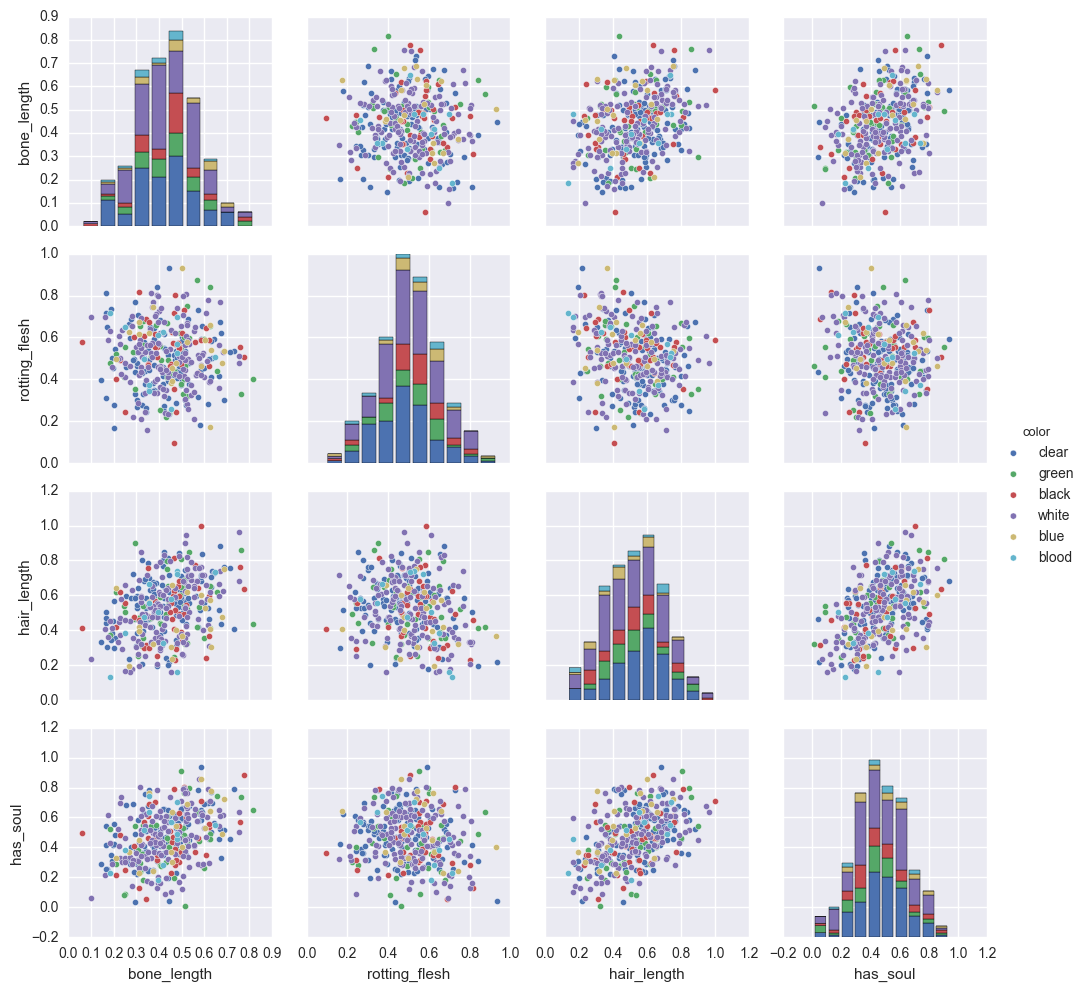

In [9]:
sns.pairplot(train[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'color']], hue='color')

Same idea again, but now the hue is based on the type of monster. One thing we can see is that there doesn't seem to be a clear linear separation of the data.

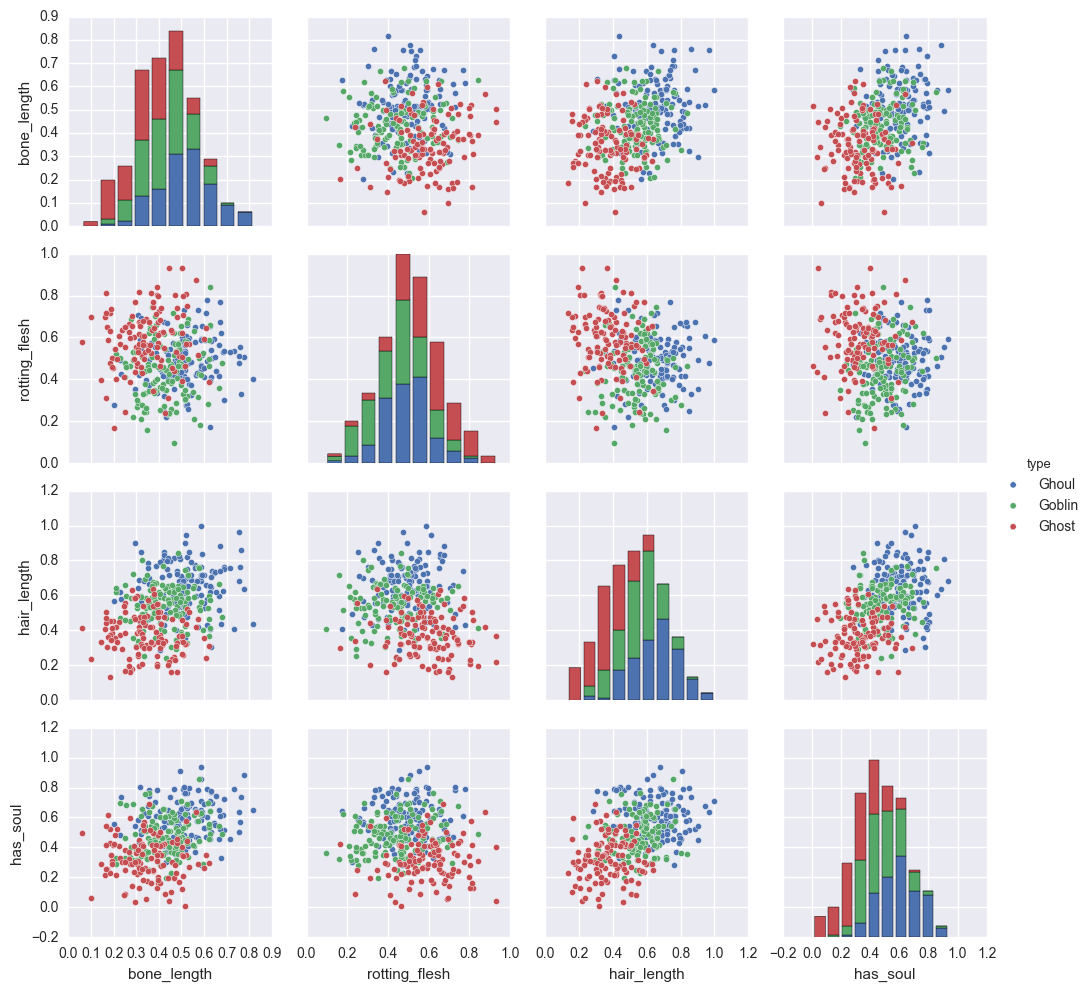

In [10]:
sns.pairplot(train[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'type']], hue='type')

## Plotting 1v1
Lets try plotting the same thing, but instead of including all 3 classes at once lets plot them 1 against 1.

In [11]:
ghosts_and_goblins = train[train.type.isin({'Ghost', 'Goblin'})]

In [12]:
ghosts_and_goblins.type.unique()

array(['Goblin', 'Ghost'], dtype=object)

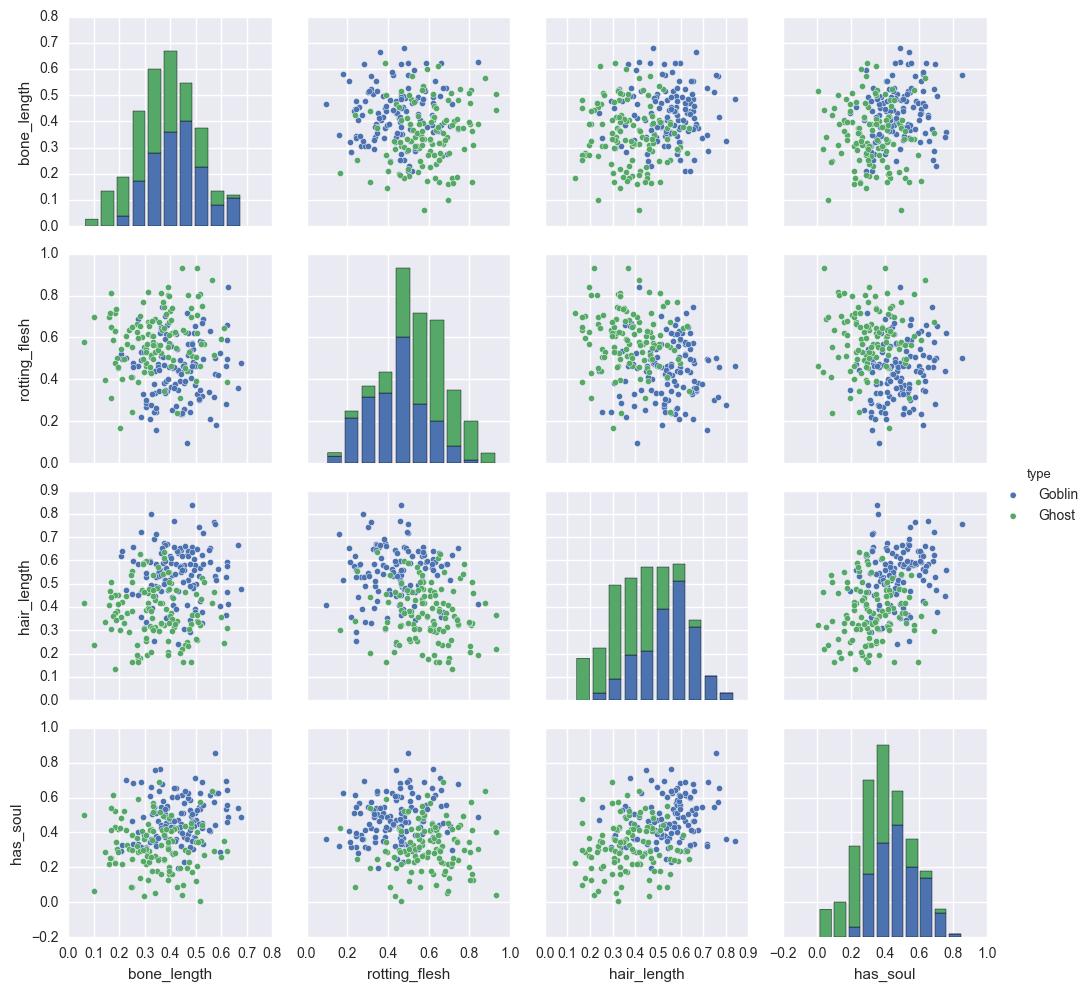

In [13]:
sns.pairplot(ghosts_and_goblins[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'type']], hue='type')

## Separations
Looks like `hair_length` and `has_soul` provides a pretty decent separation between these two.

In [14]:
ghosts_and_ghouls = train[train.type.isin({'Ghost', 'Ghoul'})]

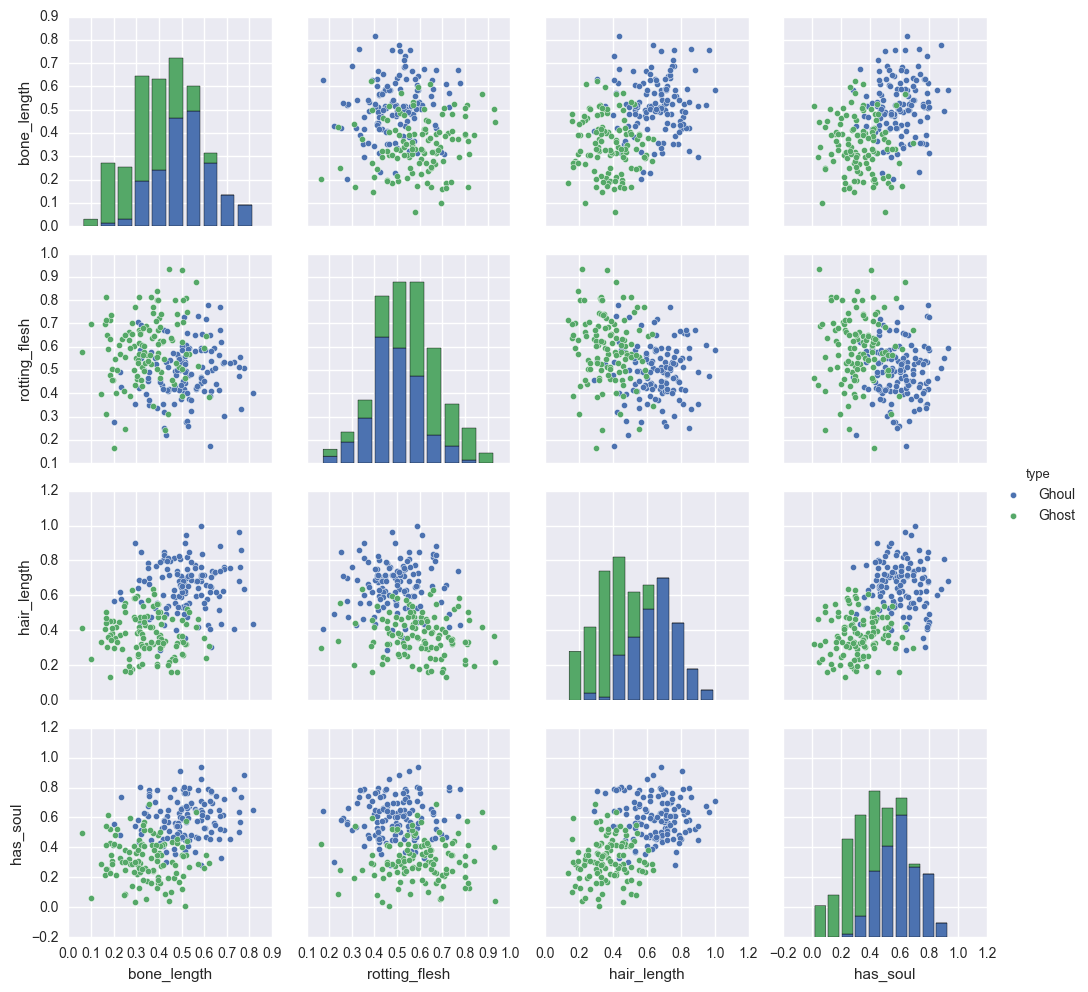

In [15]:
sns.pairplot(ghosts_and_ghouls[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'type']], hue='type')

In [16]:
goblins_and_ghouls = train[train.type.isin({'Goblin', 'Ghoul'})]

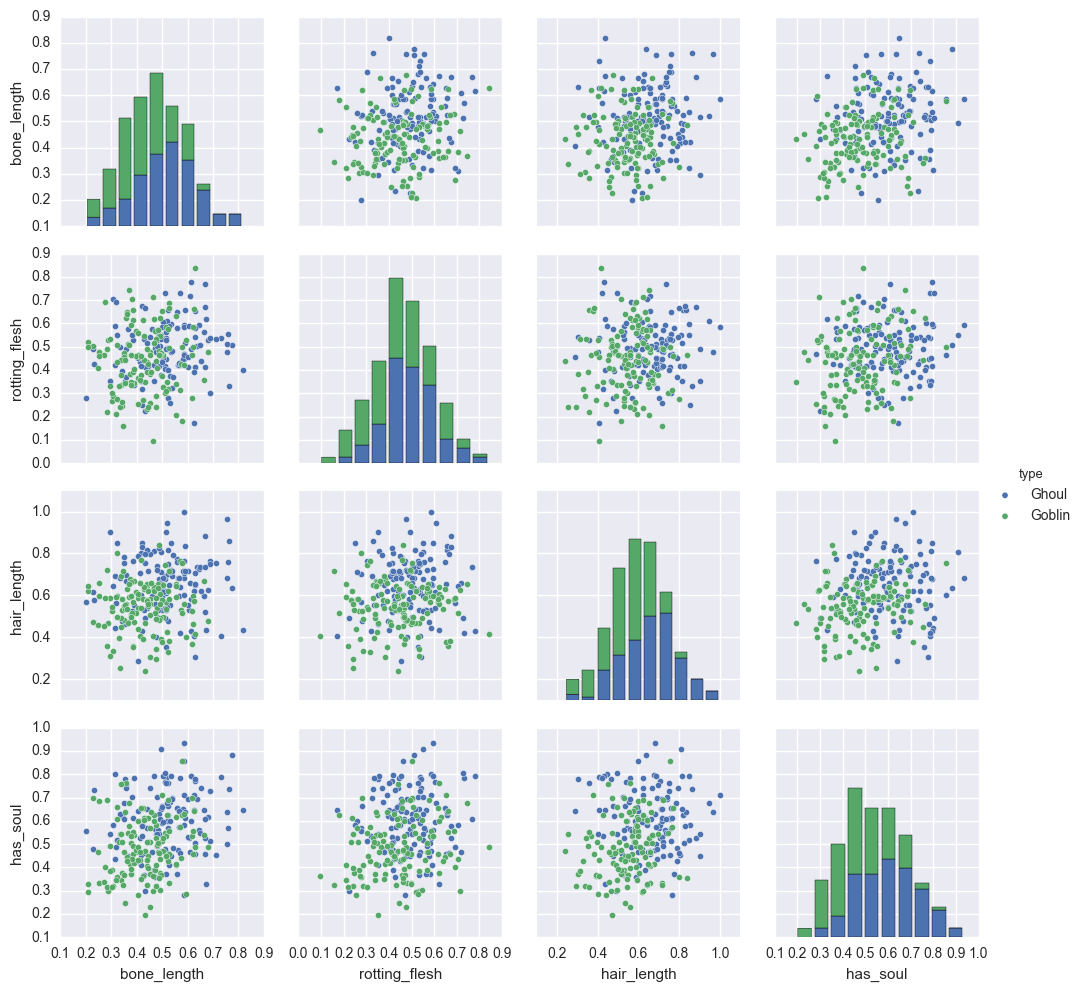

In [17]:
sns.pairplot(goblins_and_ghouls[['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'type']], hue='type')

## Correlation
Pandas has a built in correlation matrix for numerical variables so lets take a look at the matrix and plot it.

In [18]:
train[features].corr()

,bone_length,rotting_flesh,hair_length,has_soul
bone_length,1.000000,-0.041716,0.353881,0.381675
rotting_flesh,-0.041716,1.000000,-0.220353,-0.132051
hair_length,0.353881,-0.220353,1.000000,0.474835
has_soul,0.381675,-0.132051,0.474835,1.000000


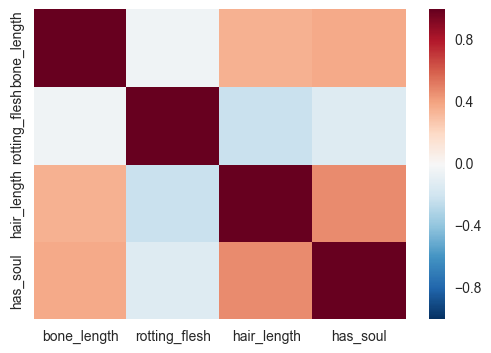

In [19]:
sns.heatmap(train[features].corr())

## Correlations
It looks like hair_length and has_soul are the most strongly correlated numeric features followed by bone_length and has_soul. Lets plot some of the data.

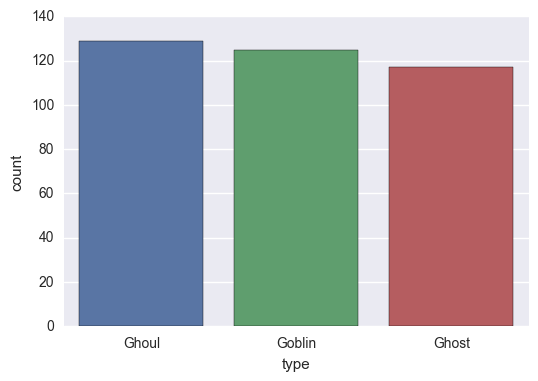

In [6]:
sns.countplot('type', data=train)

## Class Balance
The count plot above shows the classes are pretty evenly balanced.

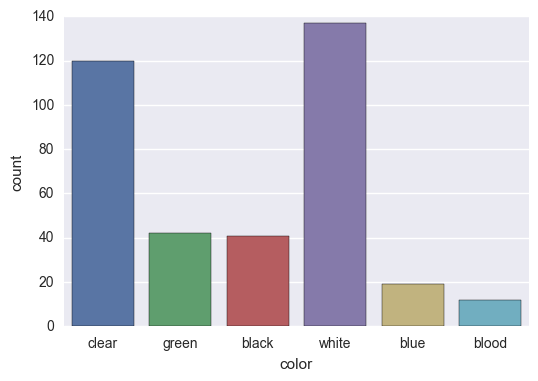

In [77]:
sns.countplot('color', data=train)

## Color Counts
The colors look fairly imbalanced.

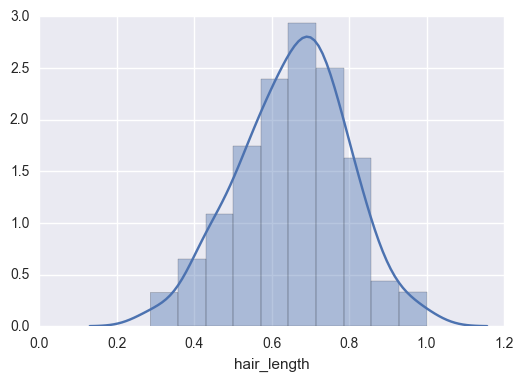

In [10]:
sns.distplot(train[train.type == 'Ghoul']['hair_length'])

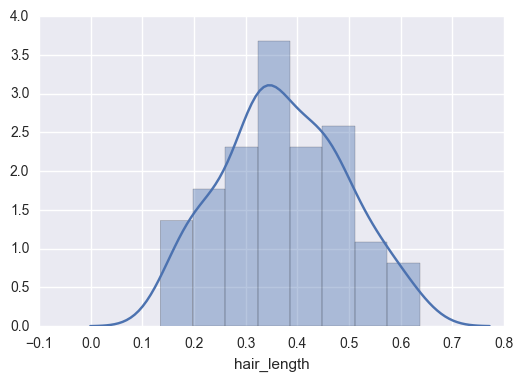

In [11]:
sns.distplot(train[train.type == 'Ghost']['hair_length'])

In [9]:
train[train.type == 'Ghoul']['hair_length'].describe()

count    129.000000
mean       0.655550
std        0.138127
min        0.287008
25%        0.556691
50%        0.667384
75%        0.751614
max        1.000000
Name: hair_length, dtype: float64

In [8]:
train[train.type == 'Ghost']['hair_length'].describe()

count    117.000000
mean       0.373186
std        0.117642
min        0.134600
25%        0.299507
50%        0.365142
75%        0.461068
max        0.636340
Name: hair_length, dtype: float64

## Violin Plots
Lets plot the distribution of the numeric variables on the X axis, the categorical color variable on the Y axis, and make one graph per type of monster. This might help us see any patterns by color or monster for the difference variables.

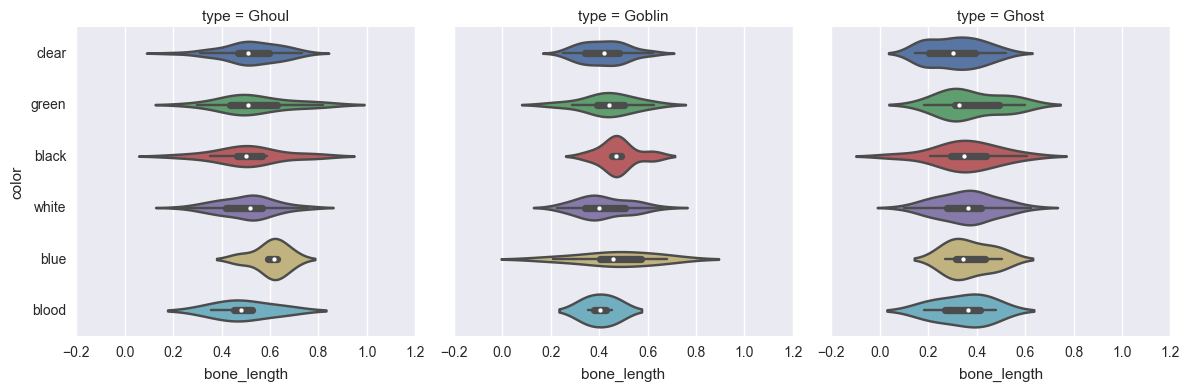

In [116]:
sns.factorplot(x='bone_length', y='color', col='type', data=train, kind='violin')

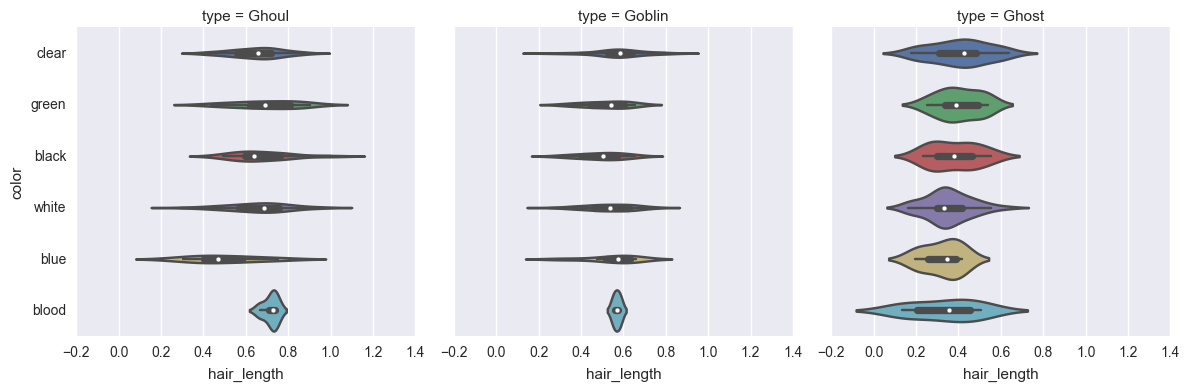

In [117]:
sns.factorplot(x='hair_length', y='color', col='type', data=train, kind='violin')

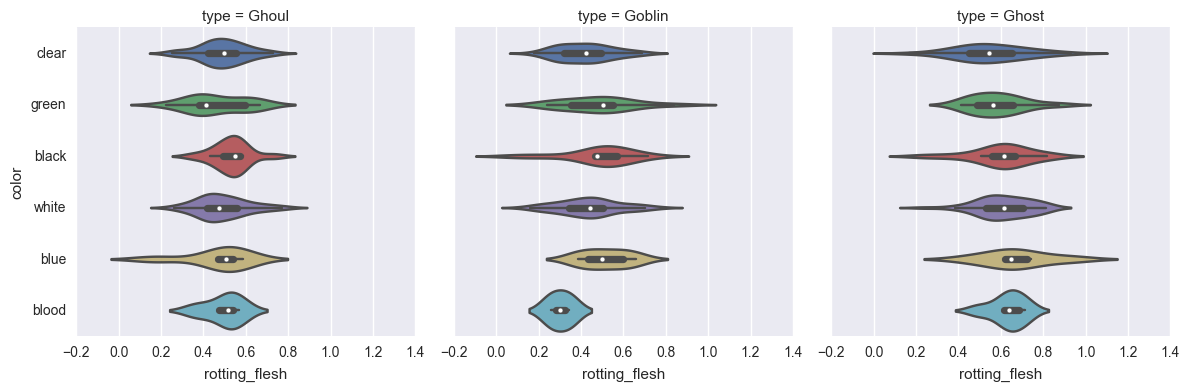

In [115]:
sns.factorplot(x='rotting_flesh', y='color', col='type', data=train, kind='violin')

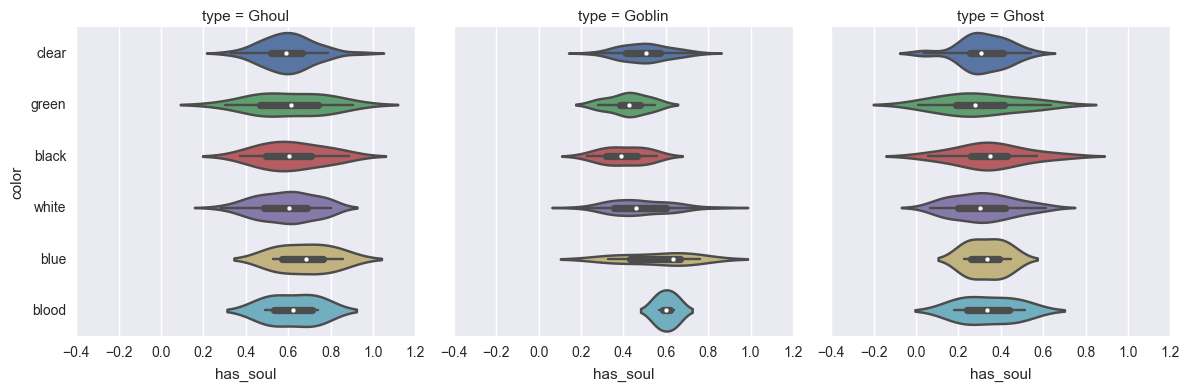

In [114]:
sns.factorplot(x='has_soul', y='color', col='type', data=train, kind='violin')

## Here's where the fun begins
Now lets start the actual machine learning. Our first task will be to split up our training data and maintain a holdout dataset that we can use for testing our changes.

### Label encoding and One Hot encoding
The color feature can't be used directly by most algorithms in sklearn. Most algorithms expect features to be either integers or floats. The first step is to use a `LabelEncoder` to transform the color labels to an integer. This will assign each color to an integer e.g. red == 1. This is great, but can cause problems with certain algorithms like logistic regression. If red is 1 and green is 2 the algorithm may learn an ordinal relationship between them that doesn't exist. Green isn't twice as much as red, the integer is just key.

### One hot encoding
This is where a `OneHotEncoder` comes into play. The OHE will take our integers created during label encoding and turn them into a vector of zeros and ones. We have six colors and lets assume red == 1 like earlier. Our OHE for red would be.

```
[0, 1, 0, 0, 0, 0]
```

The indices of the OHE vector correspond to the numeral encoding of the label. So in this example, the position for "1" is hot and all others are 0. The indexes start at the left `[0, 1, 2, 3, 4, 5]`.

In [9]:
# Stack the train and test data vertically to prepare features
all_data = pd.concat((train, test), ignore_index=True)

In [54]:
# Label encode and one hot encode the colors
color_le = LabelEncoder()
color_le.fit(all_data['color'])
all_data['color_label'] = color_le.transform(all_data.color)
colorOHE = OneHotEncoder(sparse=False)
colors = np.reshape(all_data.color_label.values, (all_data.color_label.shape[0], 1))
colors = colorOHE.fit_transform(colors)
colors.shape

(900, 6)

## Create feature interaction of degree 3
If we have 3 features like x, y, and z this will output `x + y + z + x*y + x*z + y*z + x*y*z`. So our original 4 numeric features will be returned plus new features that are the multiplications of those 4 original features. If `include_bias` is `True` it will also output a 1, which we don't want. Setting `interaction_only=True` stops `PolynomialFeatures` from including things like `x*x`.

In [32]:
poly = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
poly.fit(all_data[numeric_features])
poly_features = poly.transform(all_data[numeric_features])
poly_features.shape

(900, 14)

## Now stack polynomial and color features
Now we add the one hot encoded colors to the polynomial features and split the data back into training and test data. At this point everything is numpy arrays and we are out of Pandas DataFrames.

In [50]:
X = np.hstack((poly_features, colors))
X_all_train = X[:train.shape[0], :]
X_submit = X[train.shape[0]:, :]
y = train['type'].values
X_train, X_test, y_train, y_test = train_test_split(X_all_train, y, stratify=y, test_size=0.1, random_state=92016)

In [51]:
classifiers = [
    ('rf-300', RandomForestClassifier(n_estimators=300, random_state=92016, n_jobs=-1)),
    ('rf-100', RandomForestClassifier(n_estimators=100, random_state=92016, n_jobs=-1)),
    ('rf-100-all_feats', RandomForestClassifier(n_estimators=100, max_features=None, random_state=92016, n_jobs=-1)),
    ('lr', LogisticRegression(random_state=92016, n_jobs=-1)),
    ('svm-c1', SVC(random_state=92016)),
    ('svm-c10', SVC(10, random_state=92016)),
    ('svm-c50', SVC(50, random_state=92016)),
    ('xgb-depth3', xgb.XGBClassifier(objective='multi:softmax', subsample=.8, colsample_bytree=.8, seed=92016, nthread=-1)),
    ('xgb-depth6', xgb.XGBClassifier(max_depth=6, objective='multi:softmax', subsample=.8, colsample_bytree=.8, seed=92016, nthread=-1)),
    ('xgb-depth12', xgb.XGBClassifier(max_depth=12, objective='multi:softmax', subsample=.8, colsample_bytree=.8, seed=92016, nthread=-1)),
    ('knn-1', KNeighborsClassifier(n_neighbors=1, n_jobs=-1)),
    ('knn-5', KNeighborsClassifier(n_neighbors=5, n_jobs=-1)),
    ('knn-7', KNeighborsClassifier(n_neighbors=7, n_jobs=-1)),
]
scores = []

for name, clf in classifiers:
    clf.fit(X_train, y_train)
    result = (name, clf.score(X_test, y_test))
    scores.append(result)
sorted(scores, key=lambda x: x[1], reverse=True)

[('lr', 0.73684210526315785),
 ('rf-300', 0.71052631578947367),
 ('rf-100', 0.71052631578947367),
 ('svm-c10', 0.71052631578947367),
 ('svm-c50', 0.71052631578947367),
 ('xgb-depth3', 0.71052631578947367),
 ('xgb-depth12', 0.71052631578947367),
 ('rf-100-all_feats', 0.68421052631578949),
 ('svm-c1', 0.68421052631578949),
 ('xgb-depth6', 0.68421052631578949),
 ('knn-1', 0.68421052631578949),
 ('knn-5', 0.60526315789473684),
 ('knn-7', 0.60526315789473684)]

## Results
Looks like LogisticRegression and RandomForest did the best. When we plotted the data one vs one it looked like the classes became much more seperable.

## Feature Importance
XGBoost and RandomForest can both output feature importances. Lets take a look at those.

In [52]:
clf = xgb.XGBClassifier(objective='multi:softmax', subsample=.8, colsample_bytree=.8, seed=92016, nthread=-1)
clf.fit(X_train, y_train)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=92016, silent=True, subsample=0.8)

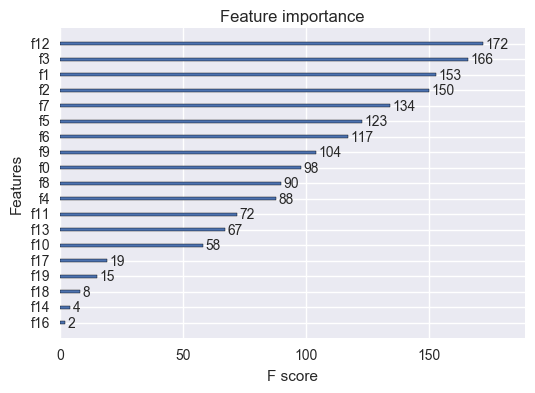

In [53]:
xgb.plot_importance(clf)

## Colors
The plot above shows the feature importances. The scores are along the X axis and the Y axis is the feature index. Features 0-13 are the numeric features. Features 14-19 are the one hot encoded colors. It looks like the colors have very little importance and we may want to just drop them entirely.

# Hyperparameter Tuning
After data cleaning and feature engineering this is the next most time consuming part. Luckily, there aren't too many knobs to tweak with LogisticRegression and it trains very quickly so we will try and tune it first to see how good we can get it.

### scikit-opt
skopt is a library that will tune hyperparameters. We give it a search space of parameters to check and an objective function. The objective function should return some kind of score. In this case, it will return the accuracy. skopt will try and minimize the value that is returned from the objective function so we return the negative accruacy score.

In [67]:
space = [
    Categorical([True, False]), # Fit intercept
    Categorical(['l1', 'l2']), # Penalty
    (1e-8, 1.0) # C    
]

In [44]:
def lr_objective(params):
    params = dict(zip(['fit_intercept', 'penalty', 'C'], params))
    clf = LogisticRegression(random_state=92016, n_jobs=2, **params)
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=2)
    return -scores.mean()

In [45]:
skopt_res = gbrt_minimize(lr_objective, space, n_calls=200, random_state=92016)
print("Best score=%.4f" % skopt_res.fun)
print('Best params: ', dict(zip(['fit_intercept', 'penalty', 'C'], skopt_res.x)))

Best score=-0.7508
Best params:  {'penalty': 'l1', 'C': 0.99968617403780569, 'fit_intercept': True}


In [68]:
def lr_objective(params):
    params = dict(zip(['fit_intercept', 'penalty', 'C'], params))
    clf = LogisticRegression(random_state=92016, n_jobs=2, **params)
    scores = cross_val_score(clf, X_all_train, y, scoring='accuracy', cv=10, n_jobs=2)
    return -scores.mean()

skopt_res = gbrt_minimize(lr_objective, space, n_calls=200, random_state=92016)
print("Best score=%.4f" % skopt_res.fun)
print('Best params: ', dict(zip(['fit_intercept', 'penalty', 'C'], skopt_res.x)))

Best score=-0.7299
Best params:  {'penalty': 'l1', 'C': 0.96840264426149258, 'fit_intercept': True}


In [69]:
best_params = {'penalty': 'l1', 'C': 0.96840264426149258, 'fit_intercept': True}
clf = LogisticRegression(random_state=92106, **best_params)
clf.fit(X_all_train, y)
preds = clf.predict(X_submit)

In [70]:
submission = np.hstack((np.reshape(test.id.values, (test.id.values.shape[0], 1)), np.reshape(preds, (preds.shape[0], 1))))

In [49]:
np.savetxt('submission.csv', submission, '%s', delimiter=',', header='id,type', comments='')

## Public LB Score
This submission scored 0.73724 on the public leader board. Lets see if we can tune XGBoost and do better.

In [91]:
space = [
    (.001, .5, 'log-uniform'), # eta aka learning_rate
    (0, .5), # gamma
    (3, 26), # max depth
    (1, 101), # min child weight
    (.5, 1.0), # subsample
    (.5, 1.0), # colsample by tree
    (0, 1.0), # lambda aka reg_lambda
    (0, 1.0), # alpha aka reg_alpha
    (20, 500), # num_estimators aka num_boosting_rounds
]

In [87]:
def objective(params):
    params = dict(zip(['learning_rate', 'gamma', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree', 'reg_lambda', 'reg_alpha', 'n_estimators'], params))
    clf = xgb.XGBClassifier(seed=92016, **params)
    score = cross_val_score(clf, X_all_train, y, scoring='accuracy', cv=10).mean()
    return -score

In [76]:
skopt_res = gbrt_minimize(objective, space, n_calls=100, random_state=92016)
print("Best score=%.4f" % skopt_res.fun)
print('Best params: ', dict(zip(['learning_rate', 'gamma', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree', 'reg_lambda', 'reg_alpha', 'n_estimators'], skopt_res.x)))

[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.8s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.0s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.6s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.6s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.8s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.2s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.5s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.8s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.5s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.9s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.3s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.6s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.9s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.8s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.9s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.9s finished


[CV] .......................................................  -   0.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .......................................................  -   0.0s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.6s finished


In [86]:
best = {'reg_alpha': 0, 'subsample': 0.65328850922043014, 'n_estimators': 110, 'colsample_bytree': 0.98301389079401447, 'gamma': 0, 'min_child_weight': 31, 'reg_lambda': 1, 'learning_rate': 0.011231056984254178, 'max_depth': 4}
clf = xgb.XGBClassifier(**best)
clf.fit(X_all_train, y)
pred = clf.predict(X_test)
submission = np.hstack((np.reshape(test.id.values, (test.id.values.shape[0], 1)), np.reshape(preds, (preds.shape[0], 1))))
np.savetxt('submission_xgb.csv', submission, '%s', delimiter=',', header='id,type', comments='')

## Didn't do better
This scored 0.72023 on the public leader board. XGBoost didn't do better lets try again, but remove the color features.

In [88]:
X = poly_features
X_all_train = X[:train.shape[0], :]
X_submit = X[train.shape[0]:, :]
y = train['type'].values
X_train, X_test, y_train, y_test = train_test_split(X_all_train, y, stratify=y, test_size=0.1, random_state=92016)

In [90]:
def objective(params):
    params = dict(zip(['learning_rate', 'gamma', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree', 'reg_lambda', 'reg_alpha', 'n_estimators'], params))
    clf = xgb.XGBClassifier(seed=92016, **params)
    score = cross_val_score(clf, X_all_train, y, scoring='accuracy', cv=10).mean()
    return -score

skopt_res = gbrt_minimize(objective, space, n_calls=500, random_state=92016)
print("Best score=%.4f" % skopt_res.fun)
print('Best params: ', dict(zip(['learning_rate', 'gamma', 'max_depth', 'min_child_weight', 'subsample', 'colsample_bytree', 'reg_lambda', 'reg_alpha', 'n_estimators'], skopt_res.x)))

Best score=-0.7362
Best params:  {'reg_alpha': 0, 'subsample': 0.55191635139568851, 'n_estimators': 213, 'colsample_bytree': 0.58118442389341829, 'gamma': 0, 'min_child_weight': 17, 'reg_lambda': 0, 'learning_rate': 0.011979387427668062, 'max_depth': 17}


In [92]:
best = {'reg_alpha': 0, 'subsample': 0.55191635139568851, 'n_estimators': 213, 'colsample_bytree': 0.58118442389341829, 'gamma': 0, 'min_child_weight': 17, 'reg_lambda': 0, 'learning_rate': 0.011979387427668062, 'max_depth': 17}
clf = xgb.XGBClassifier(**best)
clf.fit(X_all_train, y)
pred = clf.predict(X_test)
submission = np.hstack((np.reshape(test.id.values, (test.id.values.shape[0], 1)), np.reshape(preds, (preds.shape[0], 1))))
np.savetxt('submission_xgb_nocolors.csv', submission, '%s', delimiter=',', header='id,type', comments='')

## Still no dice
The above scored 0.72023 on the public leader board so still not an improvement. It looks like LogisticRegression wins.